In [133]:
import yfinance as yf 
from yahoofinancials import YahooFinancials

from datetime import date, timedelta
import requests
import numpy as np
import pandas as pd
import warnings
import pandas_datareader as web
import seaborn as sns 
from matplotlib.pyplot import show
from scipy import stats
warnings.filterwarnings('ignore')
today = str(date.today())

In [139]:
def calculate_growth(df, column, transpose = True):
    if transpose == True:
        sort_df = df.T.sort_index(ascending=False)[[column]]
    else:
        sort_df = df.sort_index(ascending=False)[[column]]
    growth_col = column + ' growth'
    sort_df[growth_col] = sort_df[column] / sort_df[column].shift(-1)
    return sort_df, sort_df[growth_col].iloc[0]

def get_kpi(stock_ticker):
    company_df = yf.Ticker(stock_ticker)

    income_stm = company_df.income_stmt[company_df.income_stmt.index.isin(['Total Operating Income As Reported','Net Income','Cost Of Revenue', 'Total Revenue', 'Operating Revenue', 'Gross Profit'])]
    balance_stm = company_df.balance_sheet[company_df.balance_sheet.index.isin(['Total Assets', 'Cash Cash Equivalents And Short Term Investments','Current Liabilities'])]
    cf_stm = company_df.cashflow[company_df.cashflow.index.isin(['Free Cash Flow','Operating Gains Losses'])]

    statement = income_stm.append(balance_stm).append(cf_stm)
    curr_stm = statement[statement.columns.max()]

    # KPI
    # profitability
    profitability = {
        'revenue': curr_stm['Total Revenue'],
        'cost': curr_stm['Cost Of Revenue'],
        'operating_income': curr_stm['Total Operating Income As Reported'],
        'net_profit': curr_stm['Gross Profit'],
        'total_asset': curr_stm['Total Assets'],
        'gross_margin' : company_df.info['grossMargins'],
        'operating_margin' : company_df.info['operatingMargins'],  
        'net_margin' : company_df.info['profitMargins'],    
        'ROA' : company_df.info['returnOnAssets'],
        'ROE' : company_df.info['returnOnEquity'] 
    }
    profitability = pd.DataFrame.from_dict(profitability, orient='index', columns=['Value']).reset_index()


    # Financial health
    financial_health = {
        'cashflow_over_cost' : curr_stm['Free Cash Flow'] / curr_stm['Cost Of Revenue'],
        'current_ratio' : company_df.info['currentRatio'],
        'liability_asset_ratio' : curr_stm['Current Liabilities'] / curr_stm['Total Assets']
    } 
    financial_health = pd.DataFrame.from_dict(financial_health, orient='index', columns=['Value']).reset_index()


    # Growth 
    _, operating_income_growth = calculate_growth(statement, column = 'Total Operating Income As Reported', transpose = True)
    _, free_cashflow_growth = calculate_growth(statement, column = 'Free Cash Flow', transpose = True)
    growth = {
        'revenue_growth' : company_df.info['revenueGrowth'],
        'net_income_growth' : company_df.info['earningsGrowth'],
        'operating_income_growth': operating_income_growth,
        'free_cashflow_growth': free_cashflow_growth
    }
    growth = pd.DataFrame.from_dict(growth, orient='index', columns=['Value']).reset_index()

    # Operational efficiency 
    # sales_cost_over_revenue
    # inventory_days
    all_kpi = profitability.append(financial_health).append(growth)
    output = {
        'statement' : statement,
        'profitability': profitability, 
        'financial_health': financial_health, 
        'growth': growth,
        'all_kpi': all_kpi
    }

    return output

def get_multiple_stocks_kpi(stock_list):
    """ 
    stock_list: list of stock ticker

    kpi to be collected: revenue, cost, operating income, operating margin, ROA, liability asset ratio, profit 
    """
    all_company_kpi = pd.DataFrame()
    for ticker in stock_list:
        company_kpi = get_kpi(stock_ticker = ticker)['all_kpi']
        company_kpi['Company'] = ticker
        all_company_kpi = all_company_kpi.append(company_kpi)
    
    return all_company_kpi

def plot_with_diagonal(plot_df, x_col, y_col, hue_col, title=None, diagonal = True):
    plot = sns.scatterplot(data=plot_df, x=x_col, y=y_col, hue=hue_col)
    if diagonal == True:
        x0, x1 = plot.get_xlim()
        y0, y1 = plot.get_ylim()
        lims = [0, min(x1, y1)]
        plot.plot(lims, lims, '-r')
    plot.set_title(title)
    show()

In [149]:
testdf = get_multiple_stocks_kpi(['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'AVGO', 'TSLA', 'V'])
testdf = testdf.pivot(index='Company', columns='index', values='Value').reset_index()
testdf

index,Company,ROA,ROE,cashflow_over_cost,cost,current_ratio,free_cashflow_growth,gross_margin,liability_asset_ratio,net_income_growth,net_margin,net_profit,operating_income,operating_income_growth,operating_margin,revenue,revenue_growth,total_asset
0,AAPL,0.22074,1.47250,0.465048,2.141370e+11,1.037,0.893587,0.45586,0.412124,0.007,0.26306,1.691480e+11,1.143010e+11,0.956998,0.30743,3.832850e+11,-0.043,3.525830e+11
1,AMZN,0.05951,0.20305,0.066982,4.809800e+11,1.072,-1.907121,0.47594,0.312429,2.167,0.06379,9.380500e+10,3.685200e+10,3.008818,0.10681,5.747850e+11,0.125,5.278540e+11
2,AVGO,0.07426,0.22229,1.584419,1.112900e+10,1.254,1.080983,0.74244,0.101632,1.881,0.24104,2.469000e+10,1.620700e+10,1.139332,0.31765,3.581900e+10,0.164,7.286100e+10
3,GOOGL,0.15608,0.29764,0.521218,1.333320e+11,2.149,1.158057,0.57466,0.203319,0.609,0.25902,1.740620e+11,8.429300e+10,1.126279,0.32516,3.073940e+11,0.154,4.023920e+11
4,META,0.17313,0.33361,1.689087,2.595900e+10,2.681,2.302405,0.81496,0.139185,1.141,0.32063,1.089430e+11,4.675100e+10,1.615222,0.38579,1.349020e+11,0.273,2.296230e+11
5,MSFT,0.15410,0.38488,0.903011,6.586300e+10,1.242,0.912907,0.69894,0.252804,0.200,0.36427,1.460520e+11,8.852300e+10,1.061643,0.44588,2.119150e+11,0.170,4.119760e+11
6,NVDA,0.49103,1.15658,1.625714,1.662100e+10,3.529,7.095851,0.75286,0.161742,6.500,0.53398,4.430100e+10,3.297200e+10,7.805871,0.64925,6.092200e+10,2.621,6.572800e+10
7,TSLA,0.04717,0.23736,0.055073,7.911300e+10,1.716,0.576933,0.17779,0.269636,-0.534,0.14368,1.766000e+10,8.891000e+09,0.651069,0.05497,9.677300e+10,-0.087,1.066180e+11
8,V,0.16023,0.46528,2.999239,6.567000e+09,1.398,1.101628,0.97806,0.255229,0.124,0.53865,2.608600e+10,2.100000e+10,1.116249,0.66564,3.265300e+10,0.099,9.049900e+10


## Competitive Landscape

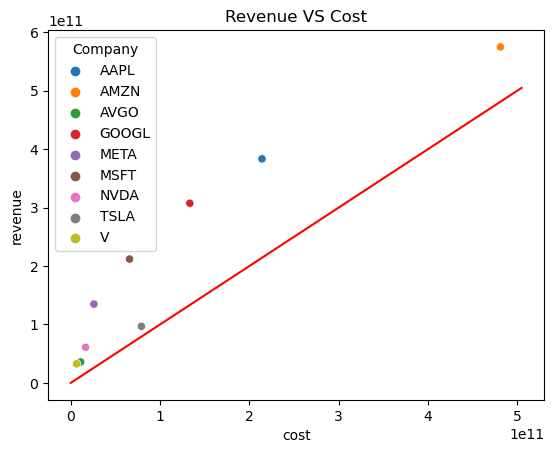

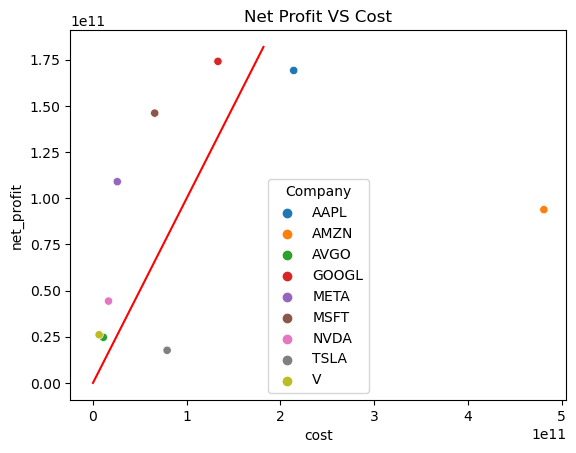

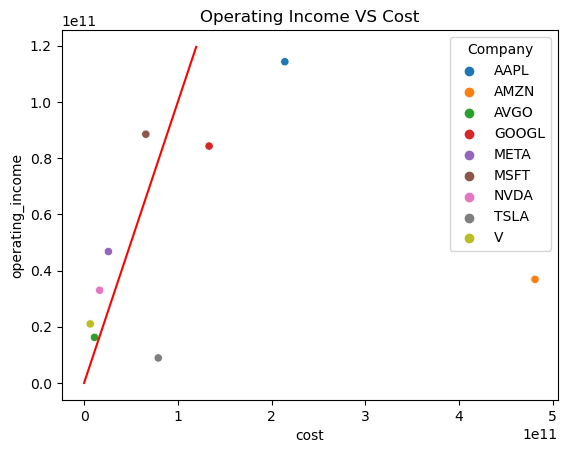

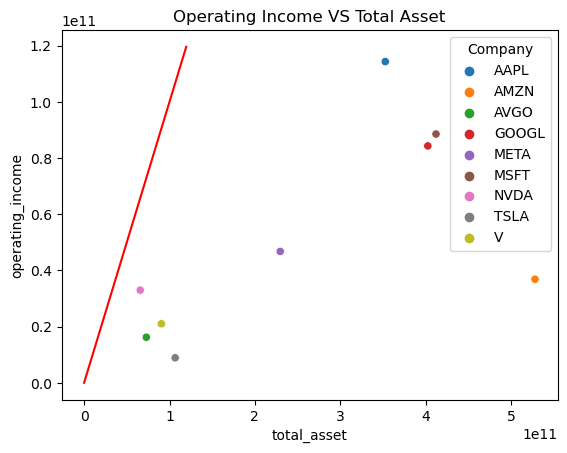

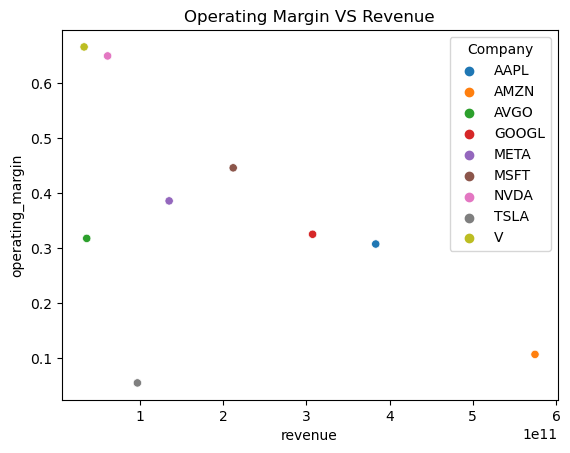

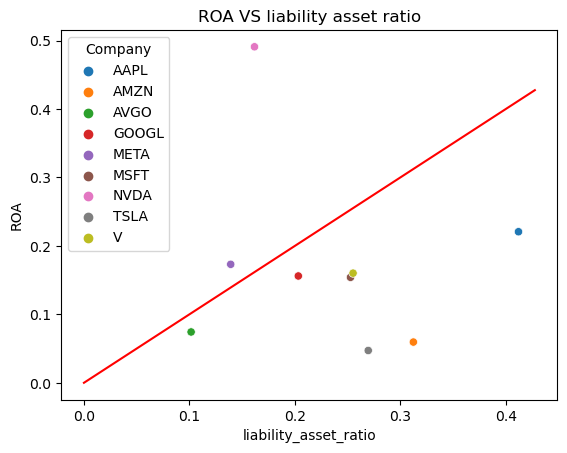

In [150]:


plot_with_diagonal(testdf, "cost", "revenue", "Company", 'Revenue VS Cost')

plot_with_diagonal(testdf, "cost", "net_profit", "Company", 'Net Profit VS Cost')

plot_with_diagonal(testdf, "cost", "operating_income", "Company", 'Operating Income VS Cost')

plot_with_diagonal(testdf, "total_asset", "operating_income", "Company", 'Operating Income VS Total Asset')

plot_with_diagonal(testdf, "revenue", "operating_margin", "Company", 'Operating Margin VS Revenue', False)

plot_with_diagonal(testdf, "liability_asset_ratio", "ROA", "Company", 'ROA VS liability asset ratio')


## Enterprise Ranking

In [165]:
testdf_pct = testdf[['Company']]
testdf_pct

for col in testdf.columns.drop(['Company']):
    pct_col = col + '_pctl'
    testdf_pct[pct_col] = [round(stats.percentileofscore(testdf[col], a, 'strict')) for a in testdf[col]]

testdf_pct = pd.melt(testdf_pct, id_vars='Company')
testdf_pct

,Company,index,value
0,AAPL,ROA_pctl,78
1,AMZN,ROA_pctl,11
2,AVGO,ROA_pctl,22
3,GOOGL,ROA_pctl,44
4,META,ROA_pctl,67
...,...,...,...
157,META,ROA_pctl_pctl,67
158,MSFT,ROA_pctl_pctl,33
159,NVDA,ROA_pctl_pctl,89
160,TSLA,ROA_pctl_pctl,0


In [167]:
import plotly.express as px

fig = px.bar(testdf_pct, x="index", y="value", color="Company", title="Percentile")
fig.show()

## Company Performance

* Market potential
    * competition / life cycle/ profit/ ROA/ Size/ Growth/ Trend
* Company performance
    * size / growth / profitability / efficiency / competition
* industrial comparison
    * profitability: total revenue / total operating income / median revenue / median operation margin / median net margin / break-even profitability
    * growth: total revenue growth rate / total operating income growth rate / median revenue growth rate / median operating income growth rate
    * efficiency: median sales general admin cost / total revenue/ median return on assets/ median return on invested capital
    * efficiency: labor productivity = revenue / # of employees
    * efficiency: market power = payable days / receivable days
* market risk:
    * profit vs cost - operating income (plot with cost as x and income or loss as y)
    * breakdown revenue (cost of revenue/ SG&A expense/ tax / net income / other cost)
* Instructions:
    * Questions addressed: The starting point of competitive intelligence is often to understand the market potential, trend, risk, and the concentration / competition intensity. One may ask questions such as,
        * What is the size of the market?
        * Does it have a significant growth and / or profit potential?
        * Which stage of the life-cycle (sun-rise, stable or saturated, sun-set) is it on?
        * What is the risk of a significant loss?
        * How intensive is the competition?
    * Analysis instructions:In general, you need to specify a few parameters for the analysis, such as, analysis module (e.g., profitability, growth, financial health, efficiency, etc.), level of industry classification (level 4 refers to the finest level) and industry, country or state, and fiscal year.